# Trabajo Práctico Final: Traxbot (Localización y Movimiento)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Parte 3. Movimiento velocidad variable

In [3]:
sys.path.append("part_3")
!tree part_3

part_3
├── ekf.py
├── parte_3.py
├── __pycache__
│   ├── ekf.cpython-37.pyc
│   ├── parte_3.cpython-37.pyc
│   └── robot.cpython-37.pyc
└── robot.py

1 directory, 6 files


In [4]:
# demo_grading() es la función de evaluación del resultado
# naive_next_pos() es la estrategia de localización
from parte_3 import demo_grading, naive_next_move, distance_between, get_heading

In [5]:
from robot import robot, angle_trunc

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_history(history,separation_threeshold = 0.1):
    """ Muestra el histórico de posición. Cada entrada es una tupla (x_hunter,y_hunter,x_target,y_target,separation)
    """
    fig,axes = plt.subplots(4,1,figsize=(22,20))
    
    x_hunter = history[:,0]
    y_hunter= history[:,1]
    x_target = history[:,2]
    y_target = history[:,3]
    separation= history[:,4]

    # XY
    axes[0].scatter(x_hunter,y_hunter,color="b");
    axes[0].scatter(x_target,y_target,color="r");
    axes[0].grid(which="both")
    axes[0].axis('square')
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].set_title("XY")
    axes[0].legend(["Cazador","Objetivo"]);

    axes[1].plot(np.arange(0,len(history)),x_hunter,color="r")
    axes[1].scatter(np.arange(0,len(history)),x_target,color="b")
    axes[1].grid(which="both")
    axes[1].set_xlabel("tiempo")
    axes[1].set_ylabel("x")
    axes[1].set_title("x,$\hat{x}$")
    axes[1].legend(["X Cazador","X Objetivo"]);

    axes[2].plot(np.arange(0,len(history)),y_hunter,color="r")
    axes[2].scatter(np.arange(0,len(history)),y_target,color="b")
    axes[2].grid(which="both")
    axes[2].set_xlabel("tiempo")
    axes[2].set_ylabel("y")
    axes[2].set_title("y,$\hat{y}$")
    axes[1].legend(["Y Cazador","Y Objetivo"]);
   
    axes[3].plot(np.arange(0,len(history)),separation,color="b")
    axes[3].grid(which="both")
    axes[3].set_xlabel("tiempo")
    axes[3].set_ylabel("Separación")
    axes[3].set_title("Separación")    
    axes[3].axhline(separation_threeshold)
    axes[3].legend(["Separación","Umbral de separación"])
    
    fig.tight_layout()
    return axes

### Estrategia de movimiento "boba"

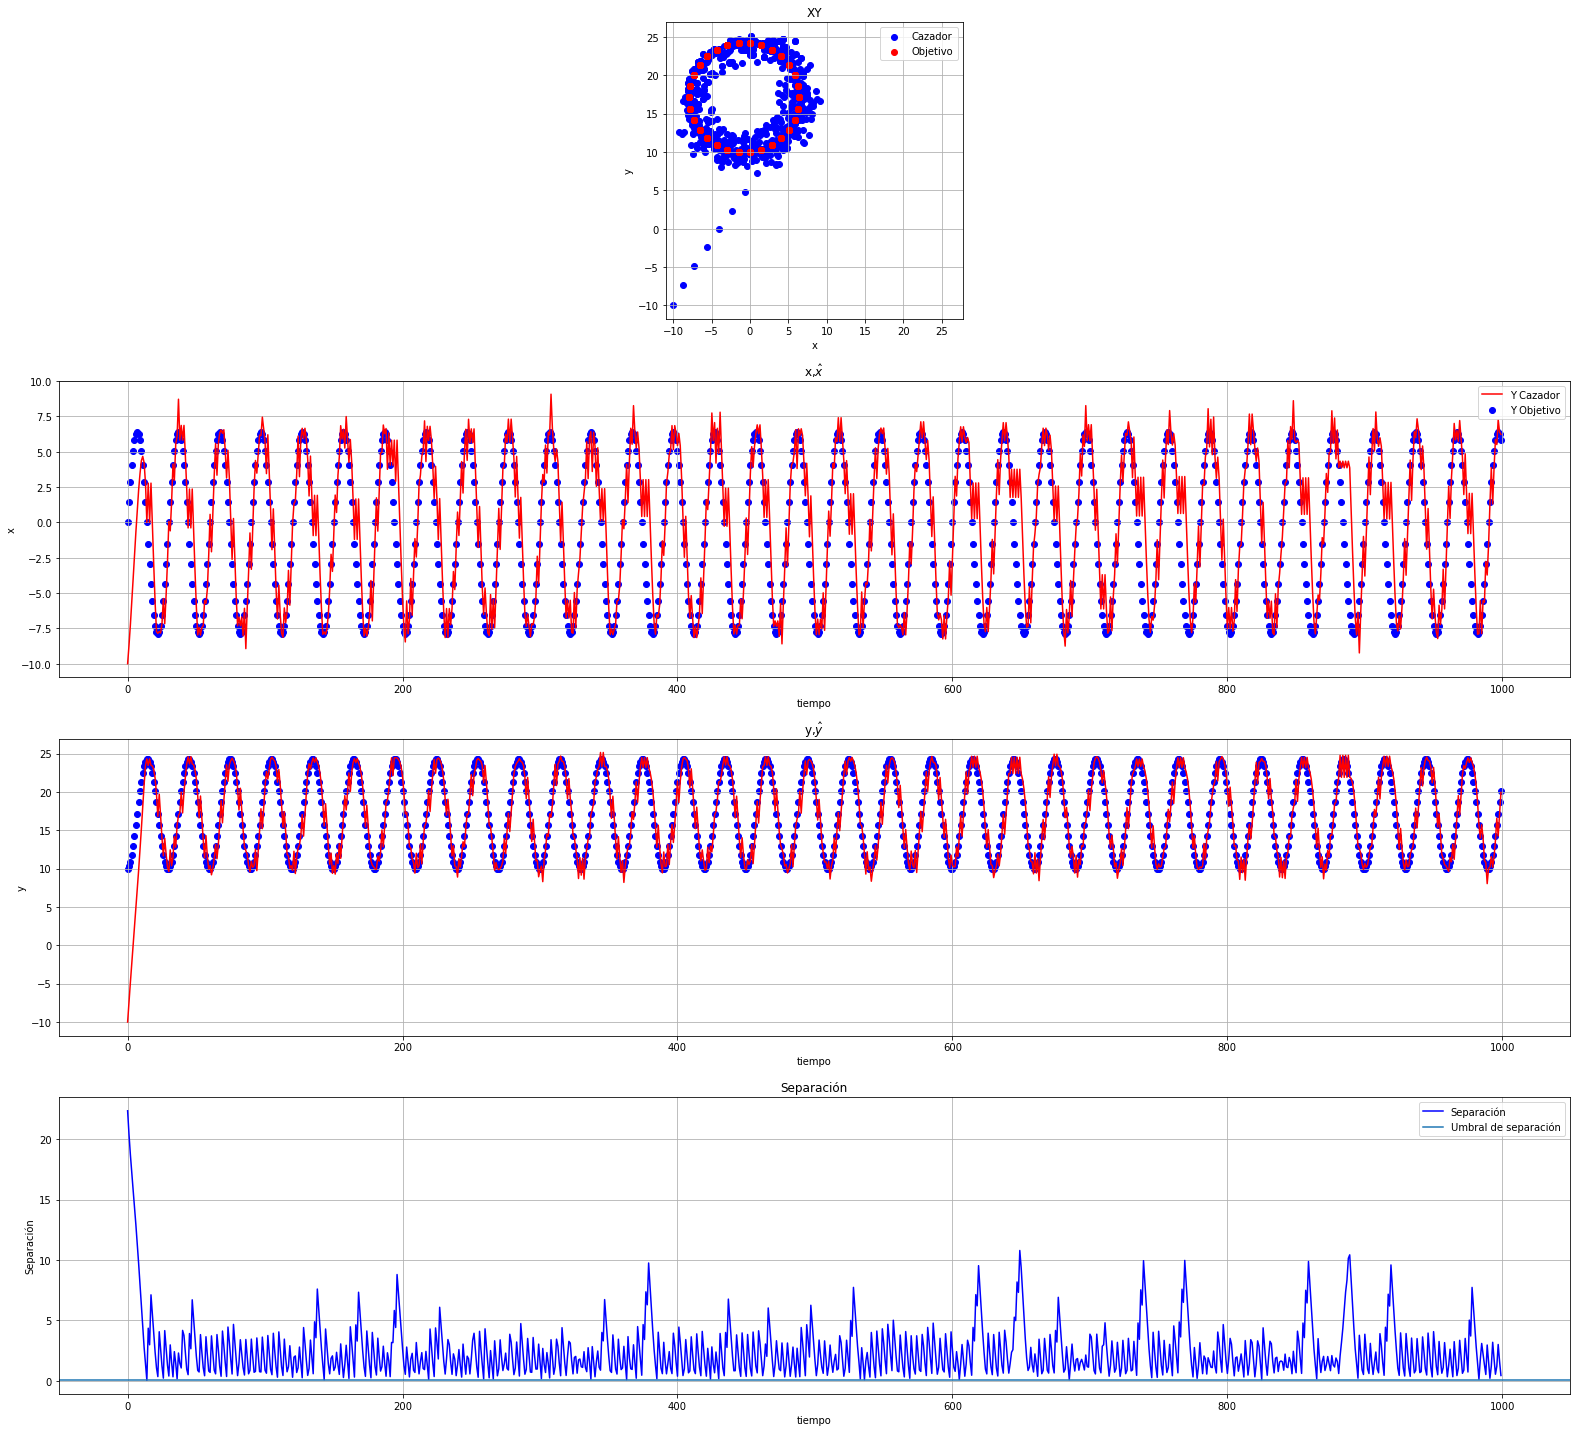

In [7]:
target = robot(0.0, 10.0, 0.0, 2*np.pi / 30, 1.5)
measurement_noise = .05*target.distance
target.set_noise(0.0, 0.0, measurement_noise)
hunter = robot(-10.0, -10.0, 0.0)

caught, history = demo_grading(hunter, target, naive_next_move)
plot_history(history,0.02*target.distance);

In [8]:
N_ATTEMPTS = 50
caughts = 0
for i in range(N_ATTEMPTS):
    target = robot(0.0, 10.0, 0.0, 2*np.pi / 30, 1.5)
    measurement_noise = .05*target.distance
    target.set_noise(0.0, 0.0, measurement_noise)
    hunter = robot(-10.0, -10.0, 0.0)
    caught, _ = demo_grading(hunter, target, naive_next_move)
    caughts+=caught
print("Total de aciertos: {}. Total de intentos: {}. Tasa de acierto: {:02}%".format(caughts,N_ATTEMPTS,(caughts/N_ATTEMPTS)*100.0))

You got it right! It took you  930  steps to catch the target.
You got it right! It took you  23  steps to catch the target.
You got it right! It took you  865  steps to catch the target.
You got it right! It took you  14  steps to catch the target.
You got it right! It took you  521  steps to catch the target.
You got it right! It took you  908  steps to catch the target.
You got it right! It took you  565  steps to catch the target.
You got it right! It took you  519  steps to catch the target.
You got it right! It took you  866  steps to catch the target.
You got it right! It took you  653  steps to catch the target.
You got it right! It took you  353  steps to catch the target.
You got it right! It took you  575  steps to catch the target.
You got it right! It took you  506  steps to catch the target.
You got it right! It took you  482  steps to catch the target.
You got it right! It took you  545  steps to catch the target.
You got it right! It took you  26  steps to catch the tar

Conclusiones: 
- La estrategia "boba" funciona en algunos casos, pero con una baja tasa de aciertos. Se intentará mejorar el resultado.

### Estrategia de movimiento estimando trayectoria circular

Sabiendo que el objetivo se mueve en una trayectoria circular, una estrategia para interceptarlo puede ser detenerse en algún punto de su trayectoria y esperarlo allí hasta que se acerque, y una vez que esté cerca interceptarlo. 

Para esto es necesario:

1) Obtener los parámetros de la circunferencia (centro $A$ y radio $r$) y encontrar el punto de intersección $C$ entre la ruta directa desde la posición del robot que persigue ($B$), como se muestra en el diagrama:

<center><img src="./assets/diagram_parte3.png"/></center>

El punto $\vec{C}$ está dado por:

$$
\vec{C} = \vec{A} + r \cdot \frac{\vec{B}-\vec{A}}{\lVert \vec{B} - \vec{A} \rVert}
$$

$$
C_x = A_x + r \cdot \frac{B_x-A_x}{\sqrt{(B_x-A_x)^2+(B_y-A_y)^2}} \\
C_y = A_y + r \cdot \frac{B_y-A_y}{\sqrt{(B_x-A_x)^2+(B_y-A_y)^2}}
$$

2) Una vez hallado el punto de espera, para interceptarlo se debe avanzar hasta la próxima posición del objetivo, que puede ser estimada utilizando el filtro de Kalman extendido de la parte anterior. La condición para ir en su persecución es que su próxima posición no supere la máxima distancia que está permitido avanzar (*max_distance*).

In [9]:
class ChasingStrategy:
    def __init__(self,next_target_pos_estimator):
        self.history = []
        
        self.iteration = 0
        
        # Estimación de trayectoria circular
        self.trajectory_estimation_threeshold = 0.01
        self.has_trajectory = False        
        self.x_min = 0
        self.xc = 0
        self.x_max = 0
        self.y_min = 0
        self.yc = 0
        self.y_max = 0        
        self.last_r = 99999
        self.r = 0
        
        self.intercept_x = 0
        self.intercept_y = 0
        
        self.next_target_pos_estimator = next_target_pos_estimator
        
    def estimate_circular_trajectory(self):
        hist = self.get_history()
        target_x, target_y = hist[:,3],hist[:,4]
        
        self.x_min = np.min(target_x)
        self.x_max = np.max(target_x)
        self.xc = np.mean(target_x)
        
        self.y_min = np.min(target_y)
        self.y_max = np.max(target_y)        
        self.yc = np.mean(target_y)
        
        self.r = np.mean(np.sqrt((target_x-self.xc)**2 + (target_y-self.yc)**2))
        diff = np.abs(self.r - self.last_r)
        self.last_r = self.r
        #print(diff)
        if diff < self.trajectory_estimation_threeshold:
            self.has_trajectory = True
        return self.has_trajectory
    
    def next_move(self,hunter_position, hunter_heading, target_measurement, max_distance, OTHER):        
        self.history.append(np.array([*hunter_position, hunter_heading, *target_measurement, max_distance]))
        
        next_target_pos_estimation, _ = self.next_target_pos_estimator.update_and_predict(target_measurement)
        separation_from_target = distance_between(hunter_position,next_target_pos_estimation) 
        
        # Acumular suficientes puntos hasta tener un error por debajo del umbral
        if not self.has_trajectory:
            if self.estimate_circular_trajectory():
                # Calcular intercepción
                #print("x_min: {}, x_max: {}, xc: {}".format(self.x_min,self.x_max,self.xc))
                #print("y_min: {}, y_max: {}, yc: {}".format(self.y_min,self.y_max,self.yc))
                #print("R: {}".format(self.r))
                ba = np.sqrt((hunter_position[0]-self.xc)**2 + (hunter_position[1]-self.yc)**2)
                self.intercept_x = self.xc + self.r*(hunter_position[0]-self.xc)/ba
                self.intercept_y = self.yc + self.r*(hunter_position[1]-self.yc)/ba
                #print(self.intercept_x,self.intercept_y)
            
        if self.has_trajectory:                        
            separation_from_waiting_point = distance_between(hunter_position,[self.intercept_x,self.intercept_y])
            
            
            # Si la posición del objetivo está al alcance, intentar atraparlo. 
            # De lo contrario ir al punto de espera
            if separation_from_target <= max_distance:
                heading_to_target = get_heading(hunter_position, next_target_pos_estimation)    
                distance = separation_from_target
            else:
                heading_to_target = get_heading(hunter_position, [self.intercept_x,self.intercept_y])
                min_distance_threeshold = 0.01            
                distance = min(separation_from_waiting_point,max_distance)
                if distance < min_distance_threeshold:
                    distance = 0
        else:
            # Si la trayectoria aún no está disponible avanzar hacia el 
            heading_to_target = get_heading(hunter_position, next_target_pos_estimation)
            distance = separation_from_target 
        
        heading_difference = heading_to_target - hunter_heading
        turning = heading_difference  # turn towards the target
        self.iteration += 1
        return turning, distance, OTHER
    
    def get_history(self):
        return np.array(self.history)

You got it right! It took you  59  steps to catch the target.


True

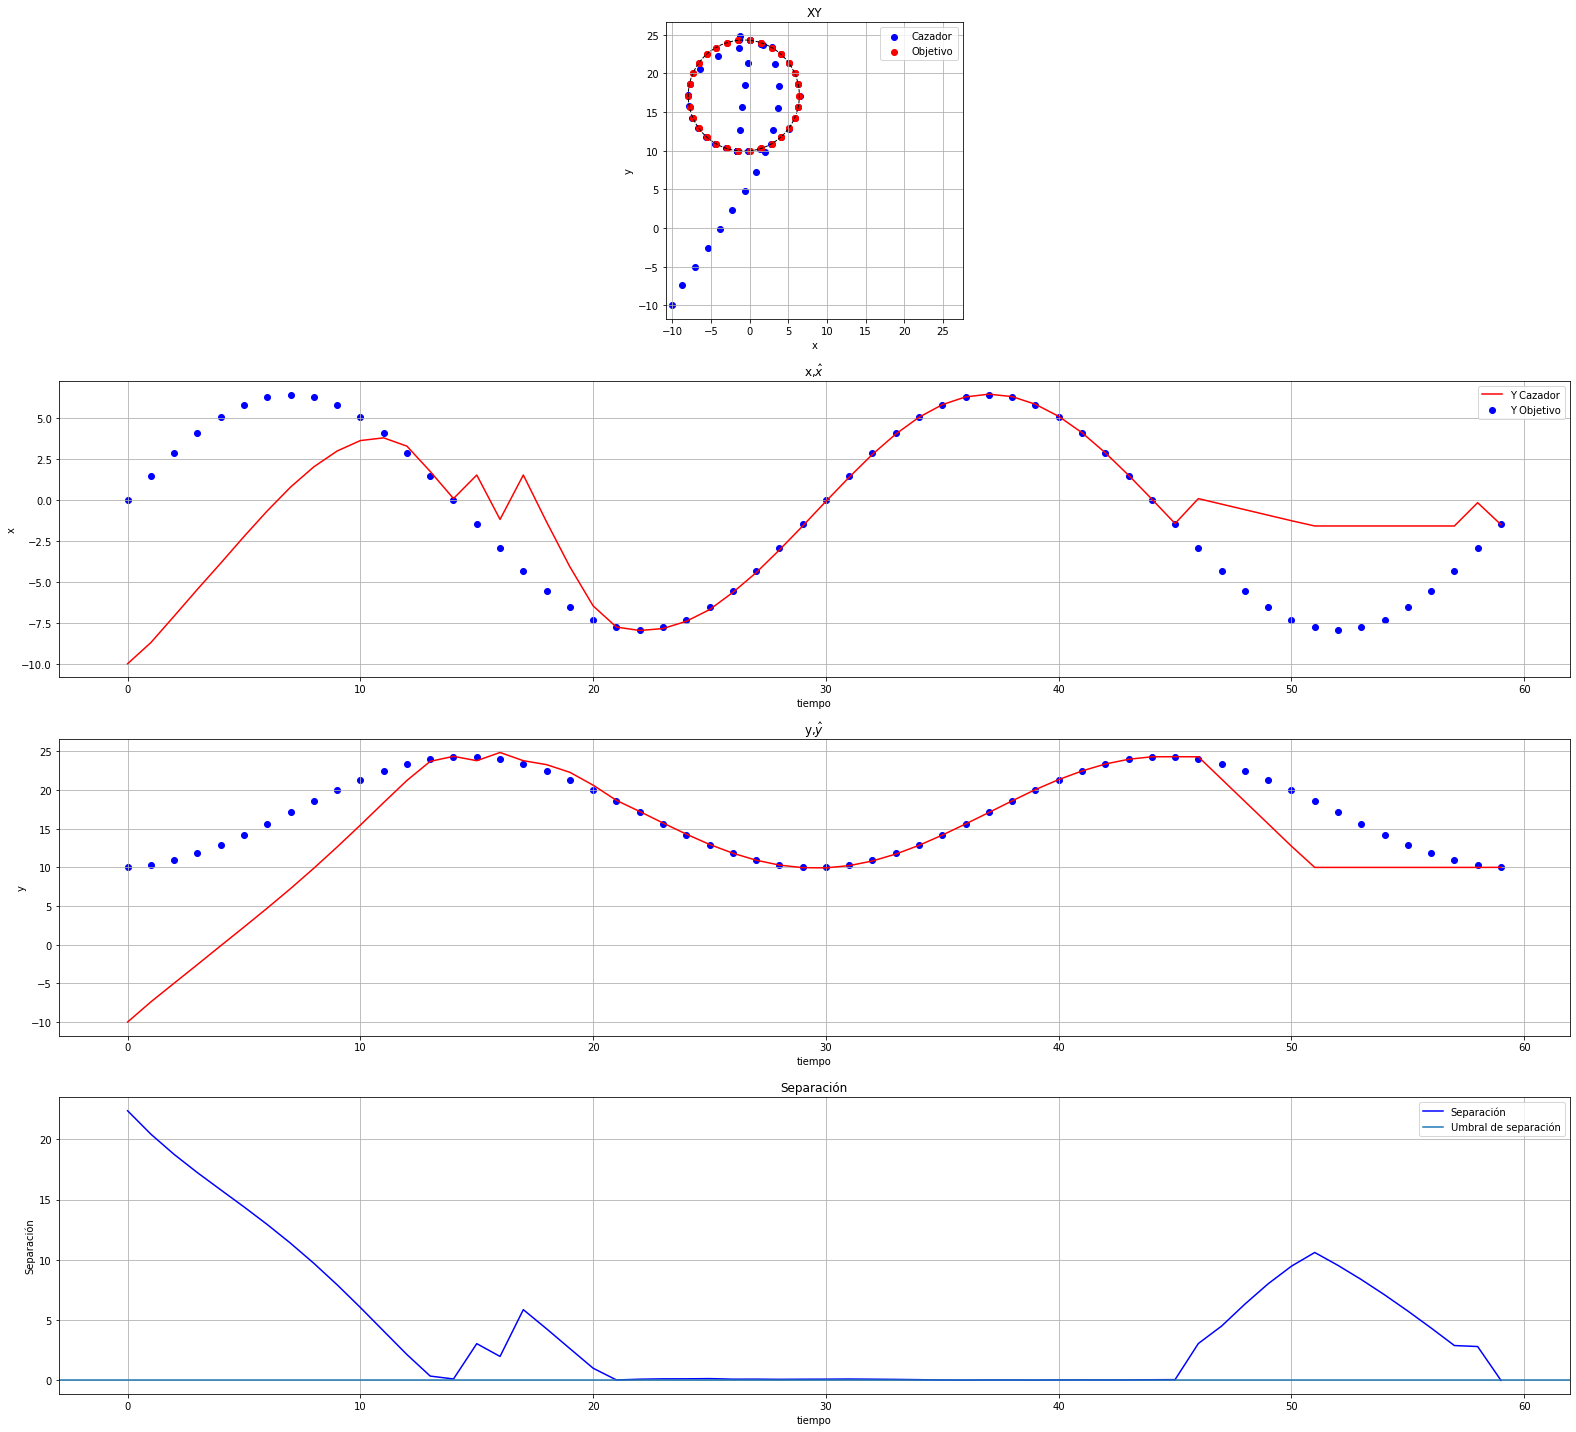

In [10]:
from ekf import ExtendedKalmanFilter, compute_state_transition_jacobian

def testcase(plot_outputs=False):
    target = robot(0.0, 10.0, 0.0, 2*np.pi / 30, 1.5)
    measurement_noise = .05*target.distance
    target.set_noise(0.0, 0.0, measurement_noise)
    hunter = robot(-10.0, -10.0, 0.0)
    
    # Estado inicial
    X = np.array([[0.], [0.], [0.], [0.], [0.]])
    P = np.diag([1000.0]*5)
    H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                  [0.0, 1.0, 0.0, 0.0, 0.0]])
    R = np.array([[measurement_noise, 0],
                 [0, measurement_noise]])
    estimator = ExtendedKalmanFilter(X,P,H,R,compute_state_transition_jacobian)
    chasing_strategy = ChasingStrategy(next_target_pos_estimator=estimator)

    caught, history = demo_grading(hunter, target, chasing_strategy.next_move)
    
    if plot_outputs:
        axes = plot_history(history,0.02*target.distance)
        target_trajectory = plt.Circle((chasing_strategy.xc, chasing_strategy.yc), chasing_strategy.r,fill=False,linestyle='dashed')               
        axes[0].add_patch(target_trajectory);    
    return caught

testcase(plot_outputs=True)

In [11]:
caughts = 0
for i in range(N_ATTEMPTS):
    target = robot(0.0, 10.0, 0.0, 2*np.pi / 30, 1.5)
    measurement_noise = .05*target.distance
    target.set_noise(0.0, 0.0, measurement_noise)
    hunter = robot(-10.0, -10.0, 0.0)
    
    # Estado inicial
    X = np.array([[0.], [0.], [0.], [0.], [0.]])
    P = np.diag([1000.0]*5)
    H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                  [0.0, 1.0, 0.0, 0.0, 0.0]])
    R = np.array([[measurement_noise, 0],
                 [0, measurement_noise]])
    estimator = ExtendedKalmanFilter(X,P,H,R,compute_state_transition_jacobian)
    chasing_strategy = ChasingStrategy(next_target_pos_estimator=estimator)

    caught, _ = demo_grading(hunter, target, chasing_strategy.next_move)
    caughts+=caught
print("Total de aciertos: {}. Total de intentos: {}. Tasa de acierto: {:02}%".format(caughts,N_ATTEMPTS,(caughts/N_ATTEMPTS)*100.0))

You got it right! It took you  29  steps to catch the target.
You got it right! It took you  59  steps to catch the target.
You got it right! It took you  61  steps to catch the target.
You got it right! It took you  24  steps to catch the target.
You got it right! It took you  59  steps to catch the target.
You got it right! It took you  14  steps to catch the target.
You got it right! It took you  45  steps to catch the target.
You got it right! It took you  73  steps to catch the target.
You got it right! It took you  26  steps to catch the target.
You got it right! It took you  74  steps to catch the target.
You got it right! It took you  70  steps to catch the target.
You got it right! It took you  31  steps to catch the target.
You got it right! It took you  67  steps to catch the target.
You got it right! It took you  14  steps to catch the target.
You got it right! It took you  59  steps to catch the target.
You got it right! It took you  59  steps to catch the target.
You got 

Conclusiones:

- Con la estrategia propuesta de utilizar el filtro EKF combinado con la estimación de trayectoria se obtiene un 100% de aciertos.